# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

In [131]:
from matplotlib import pyplot as plt
import pandas as pd
from meteostat import Point, Daily, Hourly
import datetime
import seaborn as sns
import torch
import torchtime.data
import torch.nn as nn

## 1. Data Exploration

In [120]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/new_data.xlsx")
visitor_data.head()

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


In [121]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      944 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In [122]:
visitor_data.describe()

,timestemp,value
count,4896,944.000000
mean,2023-01-28 03:24:22.500000,2.837924
min,2022-03-28 09:30:00,0.000000
25%,2022-08-28 05:48:45,0.000000
50%,2023-01-28 02:07:30,2.000000
75%,2023-06-29 22:26:15,4.000000
max,2023-11-29 18:45:00,20.000000
std,NaN,3.648123


<Axes: xlabel='timestemp'>

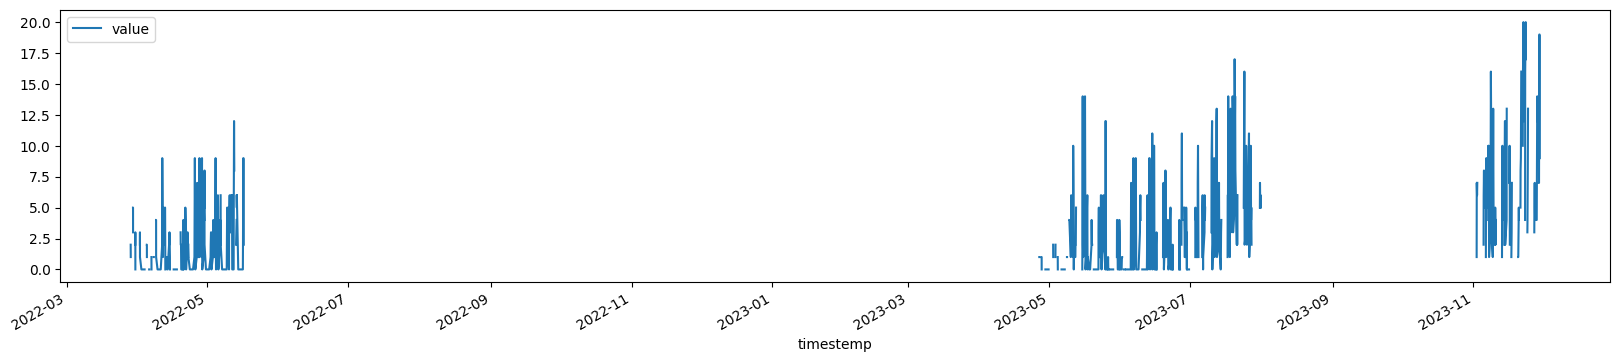

In [134]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 4))

## 2. Data Preprocessing

- Man könnte alle Daten erfassen (auch wenn nicht in der Statistik) damit dem Model kalr wird, dass am Wochende bzw. Feiertagen keiner kommt
- Missing Values mit 
    - Median
    - k-Nearest Neighbors

- Prüfungsphase
- Weekend & Holiday



- Neue datenstruktur:
    - Firaz: ab August
    - Patryk: älter als August

In [124]:
date_list = []

for i in visitor_data["timestemp"]:
    new_date = (str(i)[0:10])
    new_date = datetime.datetime.strptime(new_date,'%Y-%m-%d')
    date_list.append(new_date)

visitor_data["date"] = date_list

visitor_data

,timestemp,value,date
0,2022-03-28 09:30:00,NaN,2022-03-28
1,2022-03-28 10:45:00,NaN,2022-03-28
2,2022-03-28 13:45:00,NaN,2022-03-28
3,2022-03-28 16:15:00,NaN,2022-03-28
4,2022-03-28 17:45:00,NaN,2022-03-28
...,...,...,...
4891,2023-11-29 16:15:00,19.0,2023-11-29
4892,2023-11-29 17:45:00,9.0,2023-11-29
4893,2023-11-29 18:00:00,NaN,2023-11-29
4894,2023-11-29 18:30:00,5.0,2023-11-29


In [125]:
# add column "weekday"
# fill "weekday" with weekdays in relation to the date
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"] 
visitor_data["weekday"] = [days[weekday] for weekday in visitor_data["timestemp"].dt.dayofweek]
visitor_data

,timestemp,value,date,weekday
0,2022-03-28 09:30:00,NaN,2022-03-28,monday
1,2022-03-28 10:45:00,NaN,2022-03-28,monday
2,2022-03-28 13:45:00,NaN,2022-03-28,monday
3,2022-03-28 16:15:00,NaN,2022-03-28,monday
4,2022-03-28 17:45:00,NaN,2022-03-28,monday
...,...,...,...,...
4891,2023-11-29 16:15:00,19.0,2023-11-29,wednesday
4892,2023-11-29 17:45:00,9.0,2023-11-29,wednesday
4893,2023-11-29 18:00:00,NaN,2023-11-29,wednesday
4894,2023-11-29 18:30:00,5.0,2023-11-29,wednesday


In [126]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])
# today_hour = int(str(datetime.datetime.today())[11:13])
# today_min = int(str(datetime.datetime.today())[14:16])
# today_sec = int(str(datetime.datetime.today())[17:19])

# # get weather data thorught the date
start = datetime.datetime(2022, 3, 28)
end = datetime.datetime(today_year, today_month, today_day)

# # Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-03-28,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-29,12.6,7.0,17.4,1.8,0.0,133.0,8.6,22.7,1009.8,210.0
2022-03-30,9.0,6.9,11.2,0.8,0.0,300.0,7.2,30.6,1001.8,0.0
2022-03-31,6.4,4.5,9.0,14.9,0.0,2.0,9.7,31.7,996.7,3.0
2022-04-01,1.9,-0.2,4.5,8.7,0.0,337.0,12.2,28.1,1001.3,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-13,7.7,5.8,11.7,12.6,0.0,206.0,7.9,34.6,1001.9,90.0
2023-12-14,6.5,4.7,8.3,3.7,0.0,271.0,9.6,32.0,1016.4,NaN
2023-12-15,5.2,3.4,6.8,0.4,0.0,266.0,7.8,29.0,1035.8,NaN


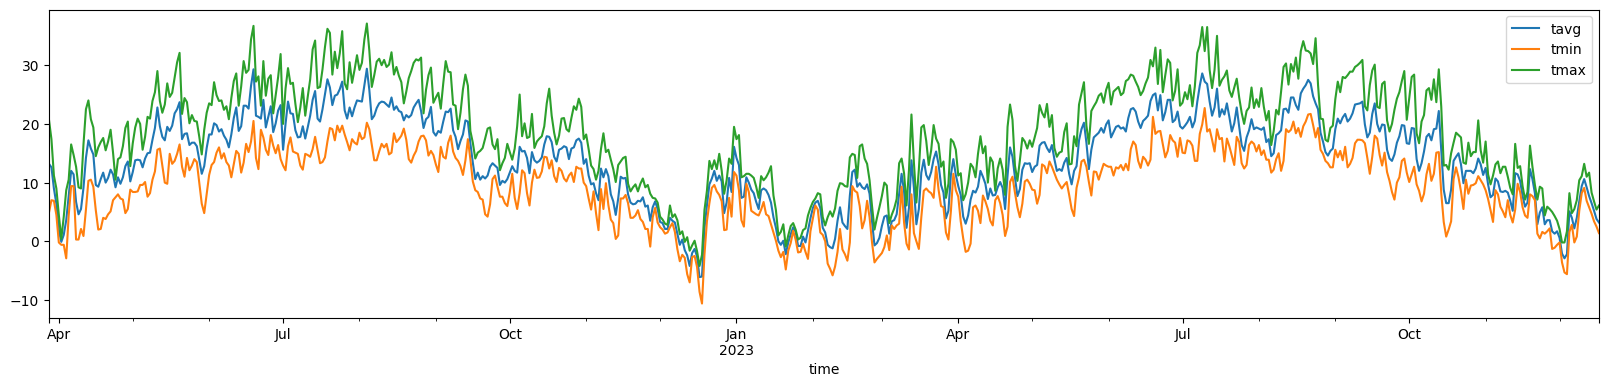

In [135]:
weather_data.plot(y=['tavg', 'tmin', 'tmax'], figsize=(20, 4))
plt.show()

In [128]:
# merge data frames
joined_df = visitor_data.merge(
    weather_data,
    left_on="date",
    right_on="time" # Die Uhrzeiten müssen auch passen | Muss man fixen
)

joined_df

,timestemp,value,date,weekday,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-03-28 09:30:00,NaN,2022-03-28,monday,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
1,2022-03-28 10:45:00,NaN,2022-03-28,monday,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2,2022-03-28 13:45:00,NaN,2022-03-28,monday,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
3,2022-03-28 16:15:00,NaN,2022-03-28,monday,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
4,2022-03-28 17:45:00,NaN,2022-03-28,monday,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2023-11-29 16:15:00,19.0,2023-11-29,wednesday,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4892,2023-11-29 17:45:00,9.0,2023-11-29,wednesday,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4893,2023-11-29 18:00:00,NaN,2023-11-29,wednesday,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4894,2023-11-29 18:30:00,5.0,2023-11-29,wednesday,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0


## 3. Build Model

In [130]:
print(visitor_data.shape)

(4896, 4)
